In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
image_path = '/kaggle/input/brain-tumor-segmentation/images'
mask_path = '/kaggle/input/brain-tumor-segmentation/masks'

image_files = sorted(os.listdir(image_path))
mask_files = sorted(os.listdir(mask_path))

images = []
masks = []

for img_file, msk_file in zip(image_files, mask_files):
    img = cv2.imread(os.path.join(image_path, img_file))
    img = cv2.resize(img, (128, 128)) / 255.0
    images.append(img)

    msk = cv2.imread(os.path.join(mask_path, msk_file), 0)
    msk = cv2.resize(msk, (128, 128)) / 255.0
    msk = np.expand_dims(msk, axis=-1)
    masks.append(msk)

images = np.array(images)
masks = np.array(masks)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [5]:
def segnet(input_shape=(128, 128, 3), num_classes=1):
    inputs = Input(shape=input_shape)

   
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

   
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    return model


In [7]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
model = segnet()
model.compile(optimizer=Adam(1e-4), loss=dice_loss, metrics=['accuracy',dice_coef])
model.summary()


I0000 00:00:1751350035.326286      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751350035.326980      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,0

 Total params: 2,109,761 (8.05 MB)

 Trainable params: 2,107,073 (8.04 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=8)

Epoch 1/40
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7514 - dice_coef: 0.0943 - loss: 0.9057

E0000 00:00:1751350095.298397      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751350095.512943      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


307/307 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.7521 - dice_coef: 0.0945 - loss: 0.9055 - val_accuracy: 0.5801 - val_dice_coef: 0.0226 - val_loss: 0.9775
Epoch 2/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9593 - dice_coef: 0.2140 - loss: 0.7860 - val_accuracy: 0.9303 - val_dice_coef: 0.2044 - val_loss: 0.7958
Epoch 3/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9771 - dice_coef: 0.3377 - loss: 0.6623 - val_accuracy: 0.9779 - val_dice_coef: 0.4229 - val_loss: 0.5773
Epoch 4/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9850 - dice_coef: 0.4899 - loss: 0.5101 - val_accuracy: 0.9885 - val_dice_coef: 0.5511 - val_loss: 0.4486
Epoch 5/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9885 - dice_coef: 0.5952 - loss: 0.4048 - val_accuracy: 0.9884 - val_dice_coef: 0.5983 - val_loss: 0.4018
Epoch 6/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9898 - dice_coef: 0.6583 - loss: 0.3417 - val_accuracy: 0.9661 - val_dic

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step


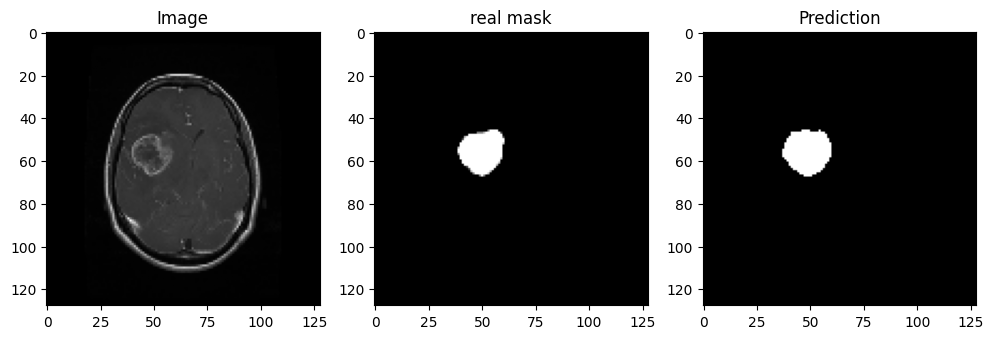

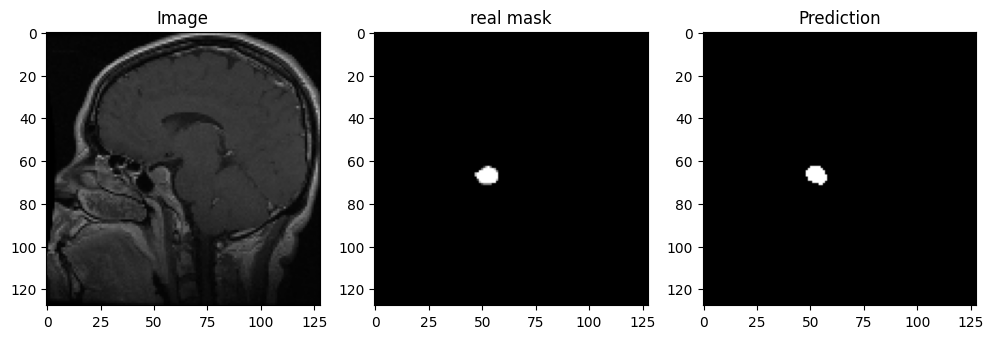

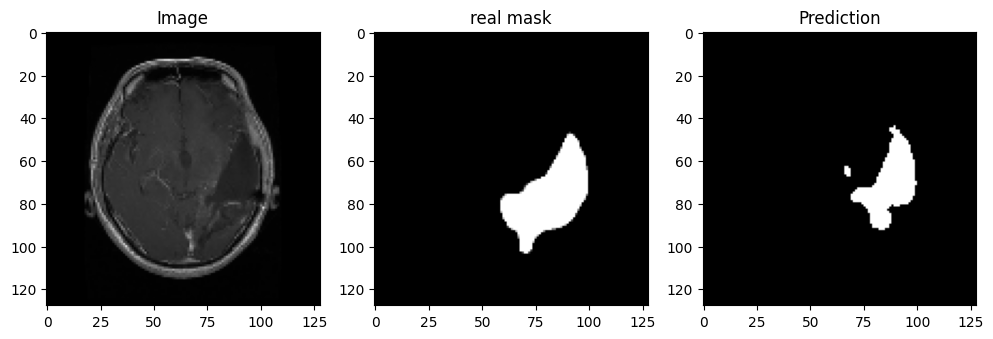

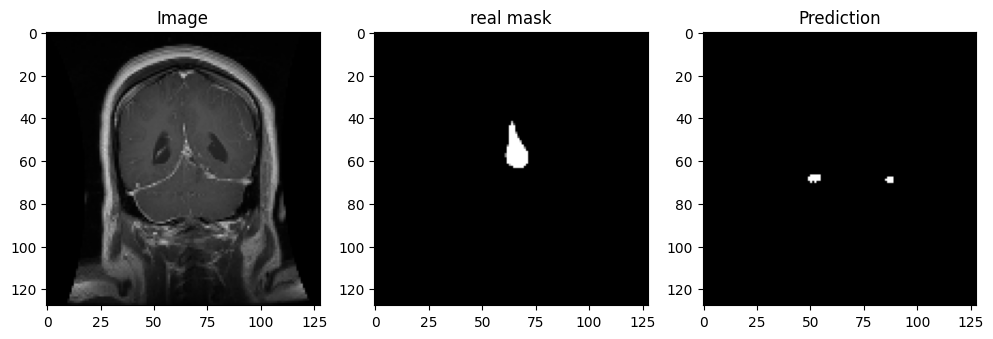

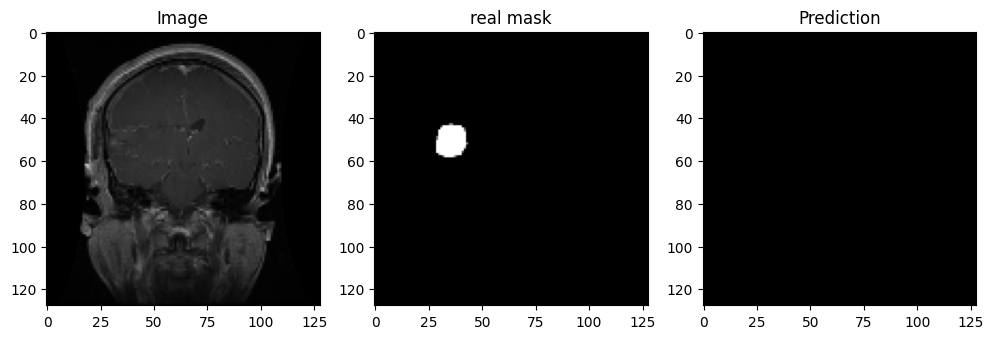

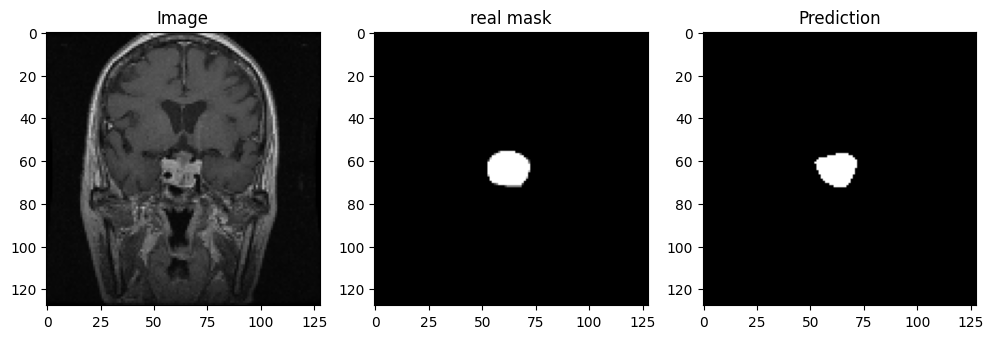

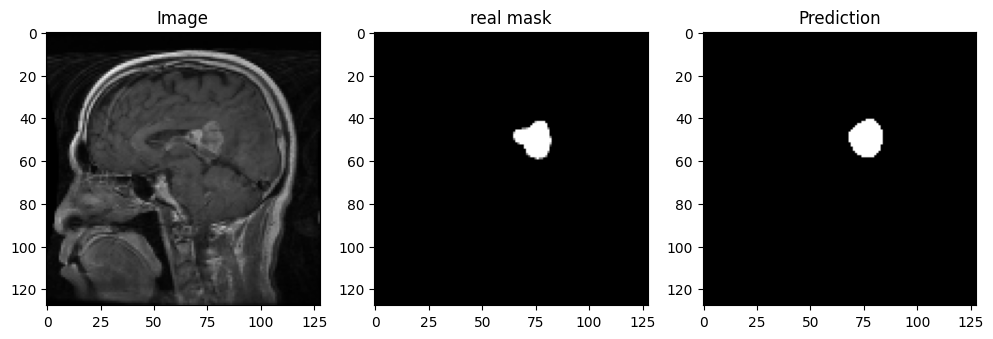

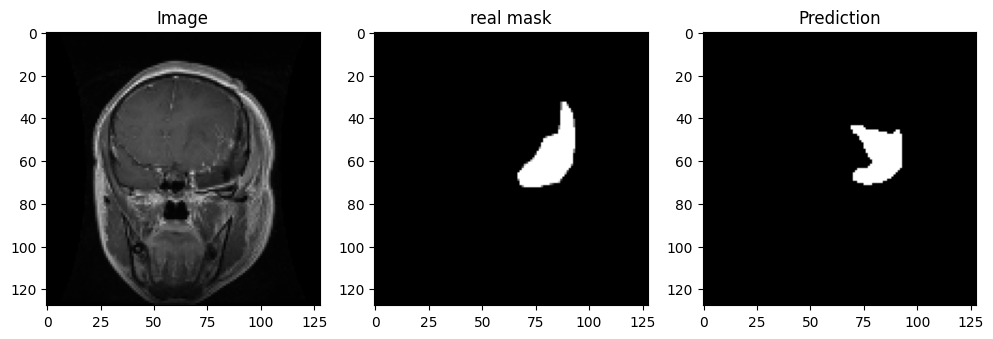

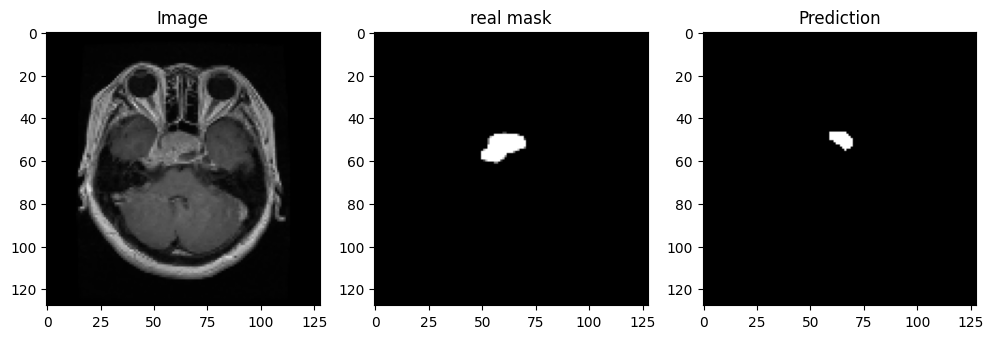

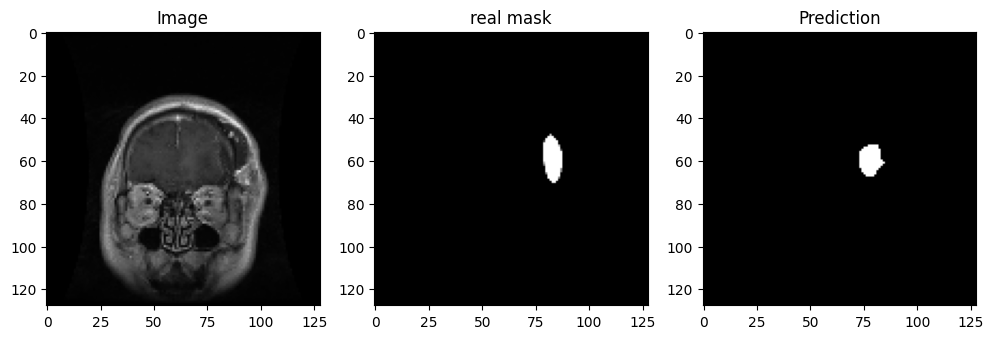

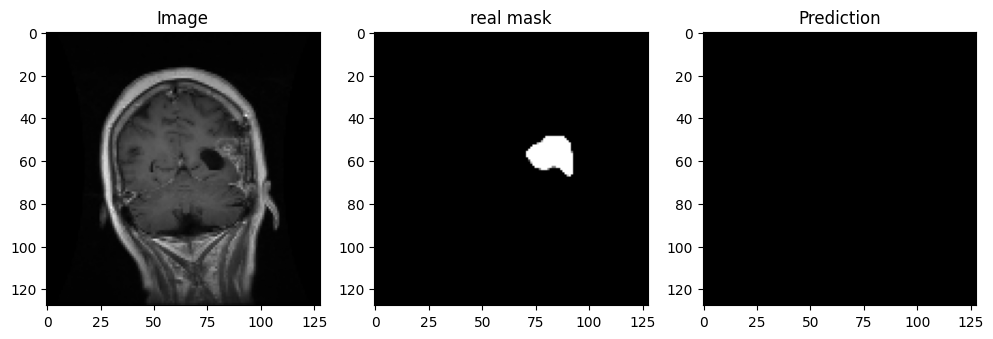

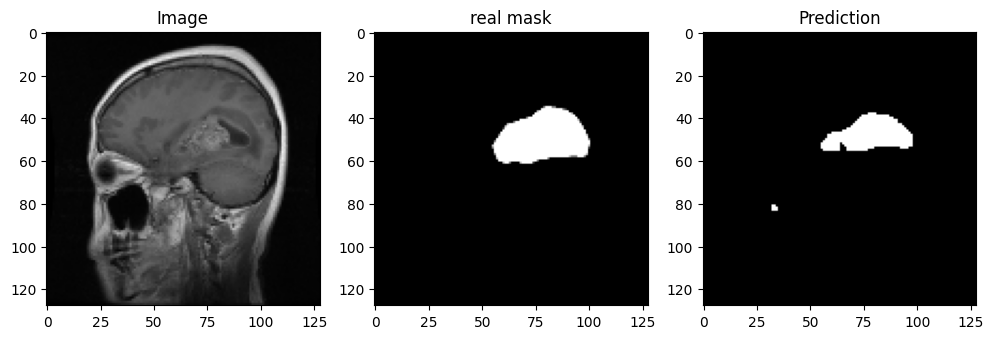

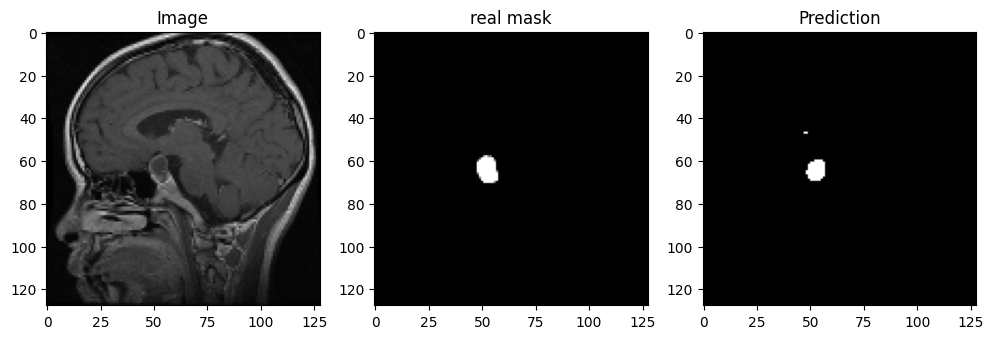

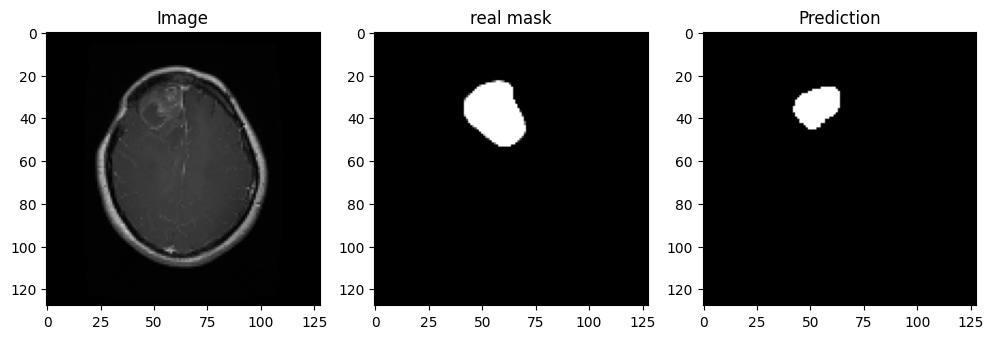

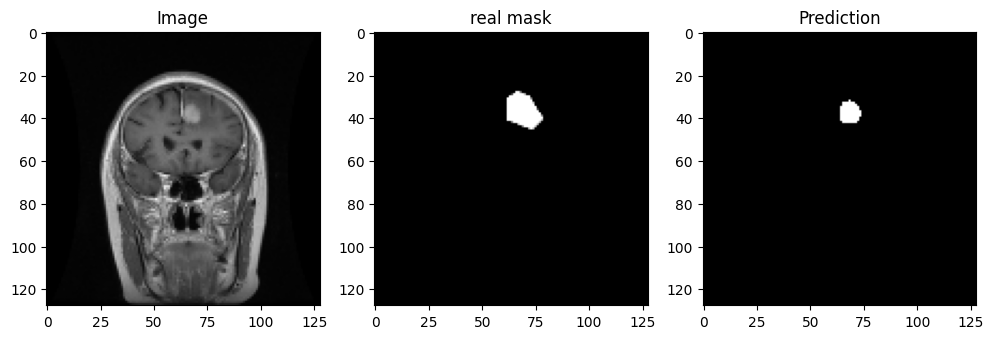

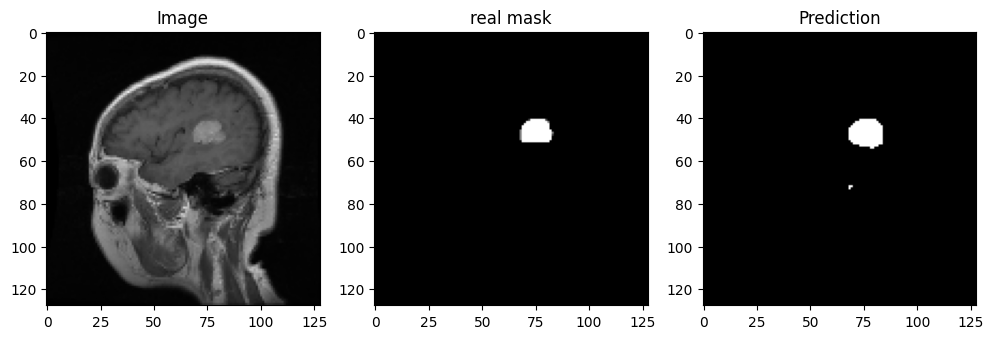

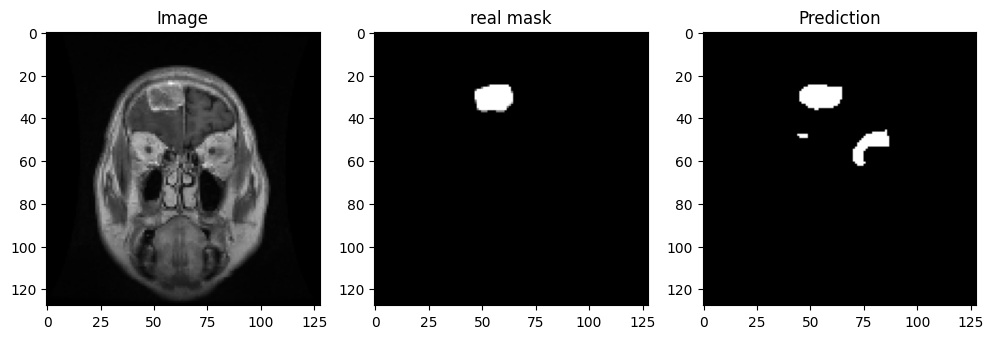

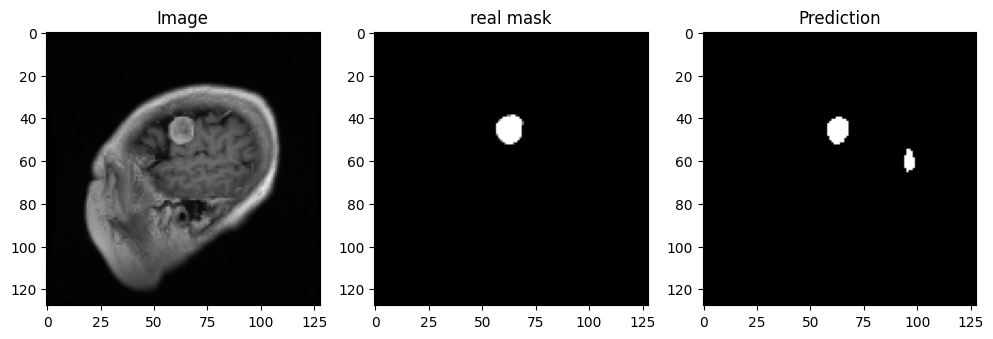

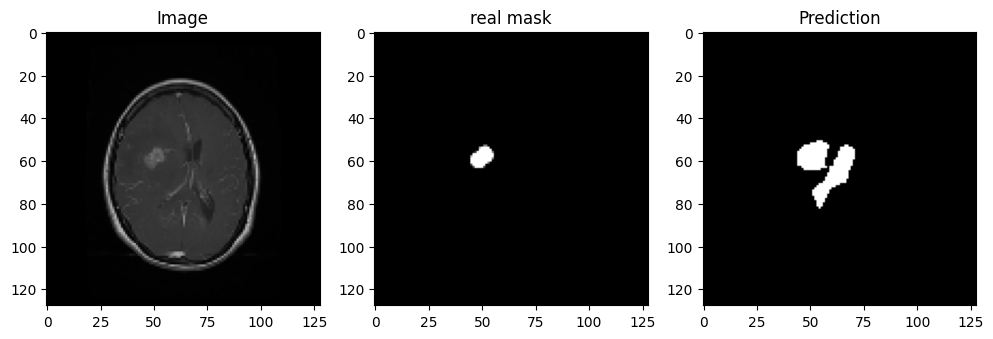

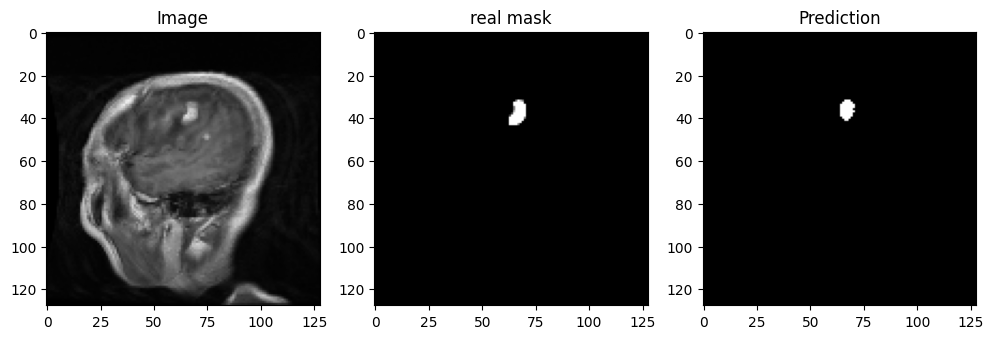

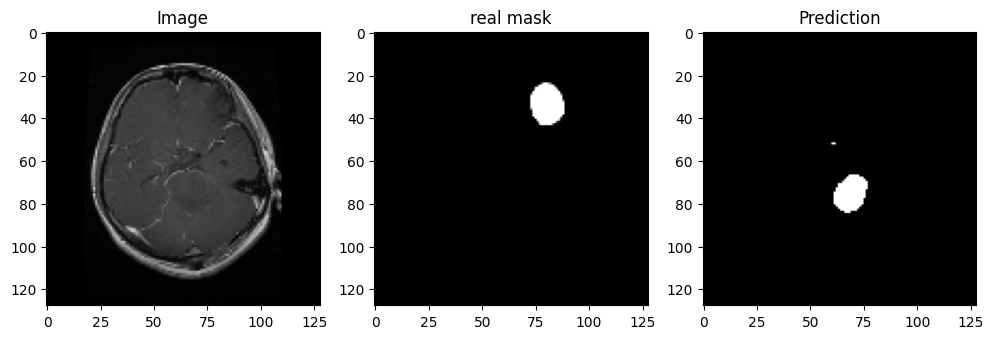

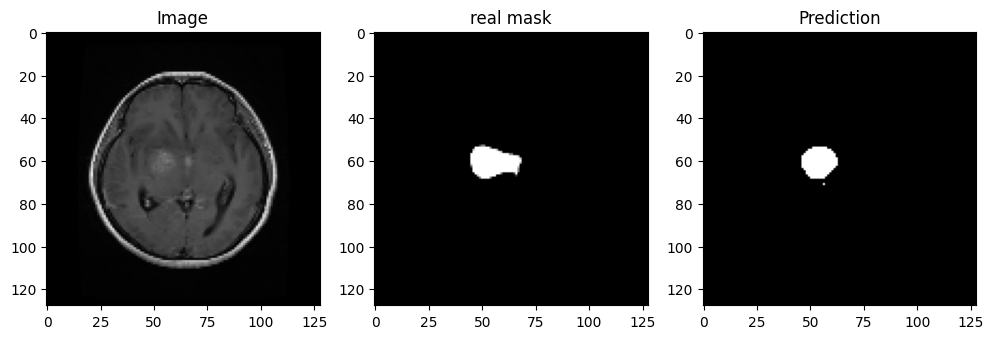

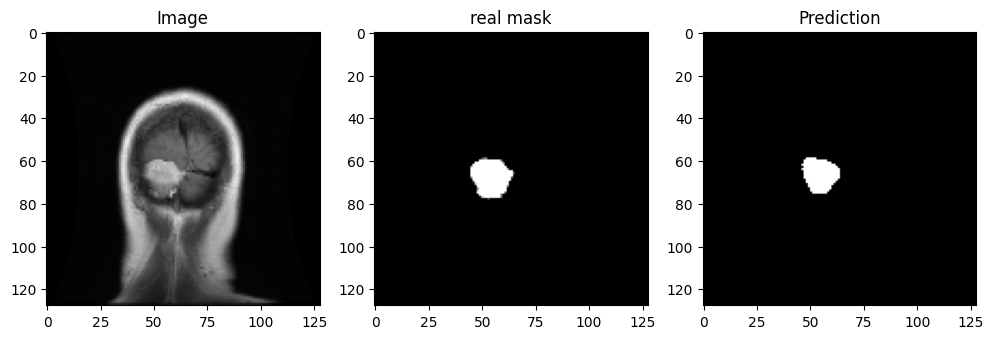

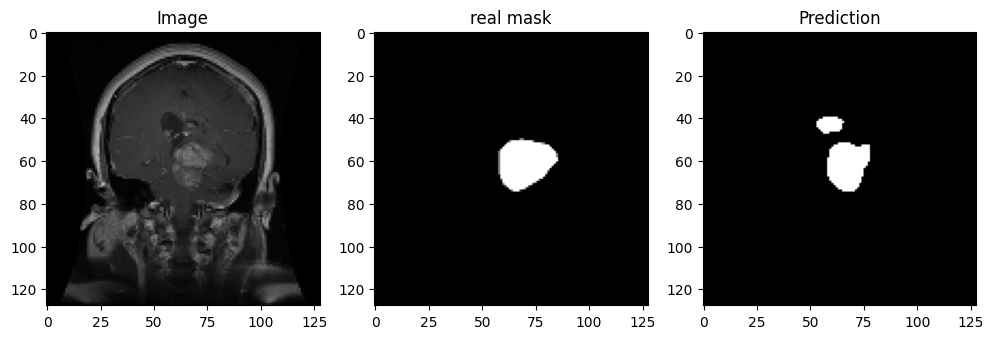

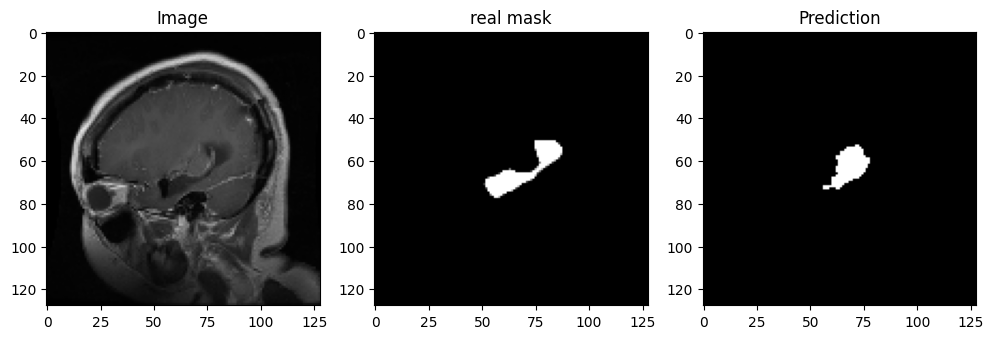

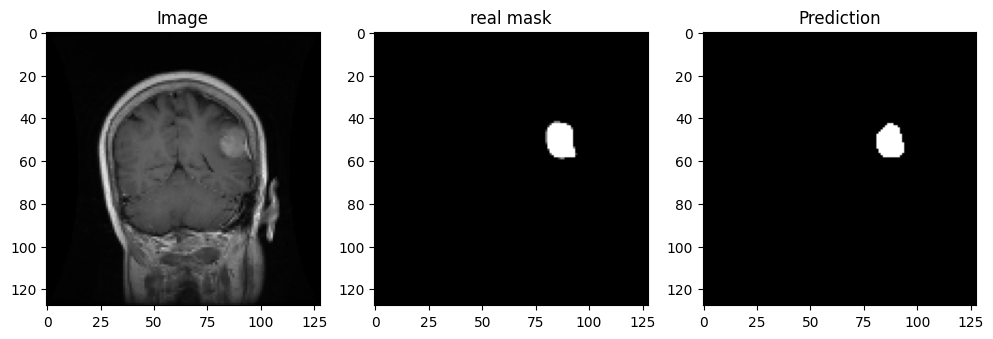

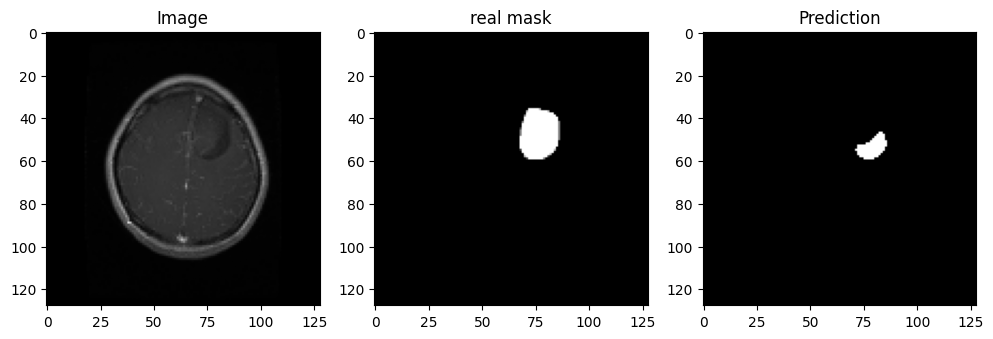

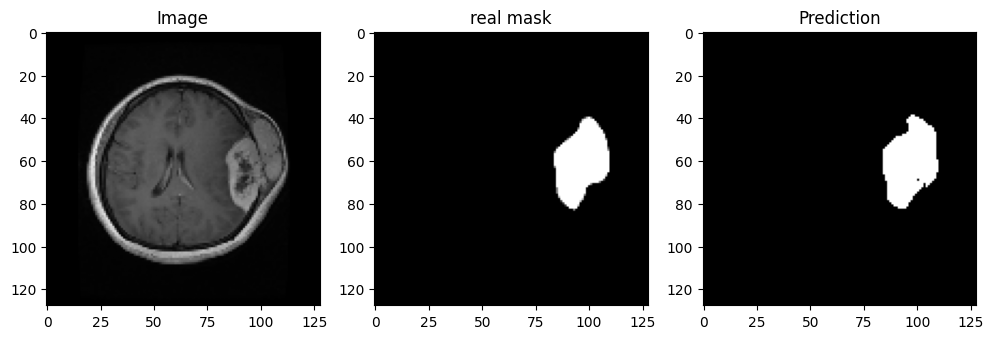

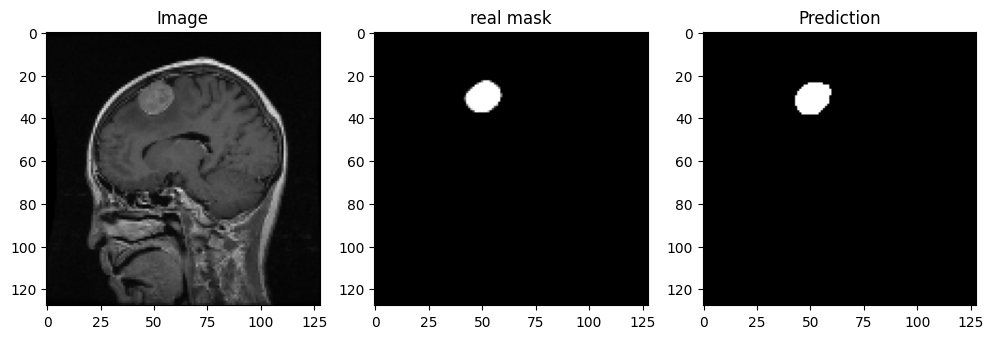

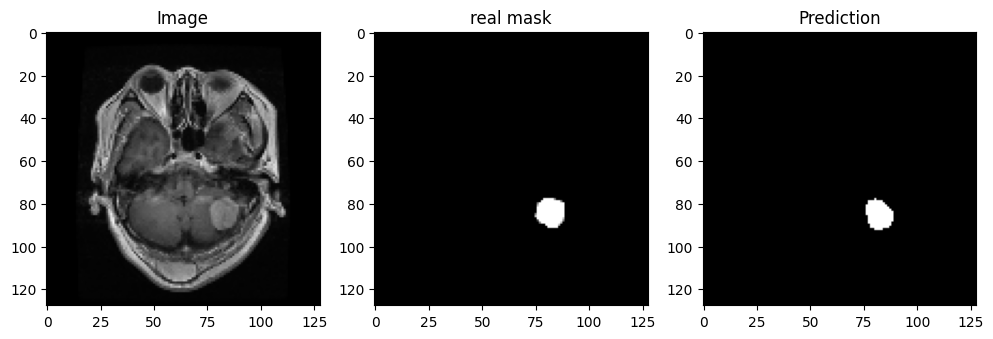

In [11]:
def display_sample(X, Y, preds, index):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(Y[index].squeeze(), cmap='gray')
    plt.title('real mask')

    plt.subplot(1, 3, 3)
    plt.imshow(preds[index].squeeze() > 0.5, cmap='gray')
    plt.title('Prediction')

    plt.show()

preds = model.predict(X_val)
for i in range(30):
    display_sample(X_val, y_val, preds, i)